In [1]:
import time
import copy
import torch
import torchvision
import matplotlib.pyplot as plt
from pathlib import Path

import pruning_utils

from torchvision import models
import torch.nn.functional as F
from torch import nn
import torch.optim as optim
from torch.optim import lr_scheduler

from load_models import load_mobilenet, load_resnet, load_vgg
from load_data import load_imagenette
from utils import batch_accuracy

if torch.cuda.is_available() == True:
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
print(device)
dtype = torch.float32

ModuleNotFoundError: No module named 'utils'

# Load Data from Pruning-Explainability Experiment

In [2]:
IMGS_PATH = Path('./exp-prune-data/imagelist.pt')
LABELS_PATH = Path('./exp-prune-data/labellist.pt')

In [3]:
img_batch = torch.stack(torch.load(IMGS_PATH)).to(device)[:16]
label_batch = torch.stack(torch.load(LABELS_PATH)).to(device)[:16]

# Load Imagenette Dataset

In [4]:
PATH = '/home/florian/data/imagenette2'
train_dl, val_dl = load_imagenette(PATH, 128, normalize=False)



image = next(iter(train_dl))[0][1].unsqueeze(0).to(device)
img_batch, label_batch = next(iter(train_dl))
img_batch, label_batch = img_batch.to(device), label_batch.to(device)

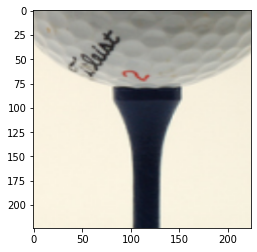

In [5]:
plt.imshow(image.cpu().squeeze().permute(1,2,0))

# Load Pre-Trained Model

In [4]:
def get_prunable_modules(model):
    modules_to_prune = []
    for i, m in enumerate(list(model.named_modules())):
        if isinstance(m[1], torch.nn.Conv2d):
            modules_to_prune.append(model.get_submodule(m[0]))
    return modules_to_prune

def load_resnet(MODEL_PATH, normalize=True, pruned=False):
    base_resnet = models.resnet18(pretrained=True)

    num_ftrs_in = base_resnet.fc.in_features
    num_ftrs_out = 10
    base_resnet.fc = nn.Linear(num_ftrs_in, num_ftrs_out)
    resnet = torch.nn.Sequential(
        ImageNetNormalization(),
        base_resnet
    )
    if pruned==True:
        modules_to_prune = get_prunable_modules(resnet)
        pruning_utils.l1_prune(modules_to_prune, .0)
    
    state_dict = torch.load(MODEL_PATH)
    resnet.load_state_dict(state_dict)
    model = resnet
    model.eval()
    return model
class ImageNetNormalization(nn.Module):
    def __init__(self, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
        super(ImageNetNormalization, self).__init__()
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)

    def forward(self, x):
        return torchvision.transforms.functional.normalize(x, self.mean, self.std)

In [5]:
#MOBILENET_PATH = './models/MobileNetV3Small.pt'
#model = load_mobilenet(MOBILENET_PATH).to(device)
RESNET_PATH = Path('./models/ResNet18.pt')
CPR2_RESNET_PATH = Path('./models/CPR2-ResNet18.pt')
CPR4_RESNET_PATH = Path('./models/CPR4-ResNet18.pt')
CPR8_RESNET_PATH = Path('./models/CPR8-ResNet18.pt')
CPR16_RESNET_PATH = Path('./models/CPR16-ResNet18.pt')

VGG_PATH = Path('./models/trained_imgnette_models/run8_vgg_100ep_ft.pt')
CPR2_VGG_PATH = Path('./models/pruned_models/local_magnitude_unstructured-pretrained/2-compression_26-01-2022_14-05-19.pt')
CPR4_VGG_PATH = Path('./models/pruned_models/local_magnitude_unstructured-pretrained/4-compression_26-01-2022_14-34-50.pt')
CPR8_VGG_PATH = Path('./models/pruned_models/local_magnitude_unstructured-pretrained/8-compression_26-01-2022_15-02-25.pt')
CPR16_VGG_PATH = Path('./models/pruned_models/local_magnitude_unstructured-pretrained/16-compression_26-01-2022_15-43-34.pt')
CPR32_VGG_PATH = Path('./models/pruned_models/local_magnitude_unstructured-pretrained/32-compression_26-01-2022_16-49-45.pt')
CPR64_VGG_PATH = Path('./models/pruned_models/local_magnitude_unstructured-pretrained/64-compression_26-01-2022_17-36-35.pt')

In [6]:
model = load_resnet(RESNET_PATH).to(device)

In [9]:
cpr2_model = load_resnet(CPR2_RESNET_PATH, pruned=True).to(device)
cpr4_model = load_resnet(CPR4_RESNET_PATH, pruned=True).to(device)
cpr8_model = load_resnet(CPR8_RESNET_PATH, pruned=True).to(device)
cpr16_model = load_resnet(CPR16_RESNET_PATH, pruned=True).to(device)

In [6]:
model = torch.load(VGG_PATH)
cpr2_model = torch.load(CPR2_VGG_PATH)
cpr4_model = torch.load(CPR4_VGG_PATH)
cpr8_model = torch.load(CPR8_VGG_PATH)
cpr16_model = torch.load(CPR16_VGG_PATH)
cpr32_model = torch.load(CPR32_VGG_PATH)
cpr64_model = torch.load(CPR64_VGG_PATH)

# Get Batch Accuracies

In [7]:
print(batch_accuracy(model, img_batch, label_batch))
print(batch_accuracy(cpr2_model, img_batch, label_batch))
print(batch_accuracy(cpr4_model, img_batch, label_batch))
print(batch_accuracy(cpr8_model, img_batch, label_batch))
print(batch_accuracy(cpr16_model, img_batch, label_batch))
print(batch_accuracy(cpr32_model, img_batch, label_batch))
print(batch_accuracy(cpr64_model, img_batch, label_batch))


1.0
1.0
1.0
1.0
1.0
0.9844
1.0


# GradCam

In [ ]:

activation = {}
def get_activation(name):
    def hook(model, input, output):
        #activation[name] = output
        activation[name] = output
    return hook

#model[1].features.register_forward_hook(get_activation('target_conv_layer'))
model[1].layer4.register_forward_hook(get_activation('target_conv_layer'))

In [ ]:
preds = model(image)
pred_index = preds.argmax(-1)
activations = activation['target_conv_layer']
activations.requires_grad_(True)
activations.retain_grad()
print(preds[:,pred_index].shape)

In [ ]:
preds[:,pred_index].backward()

In [ ]:
grads = activations.grad

In [ ]:
grads.shape

In [ ]:
pooled_grads = grads.mean(axis=(-1,-2)).squeeze(0)

In [ ]:
pooled_grads.shape

In [ ]:
activations.T.shape

In [ ]:
activations = (activations.squeeze().T * pooled_grads).T

In [ ]:
activations.shape

In [ ]:
hm = activations.mean(dim=0).squeeze()

hm.min(), hm.max()

In [ ]:
hm.shape

In [ ]:
hm = torch.nn.functional.relu_(hm)
hm.min(), hm.max()

In [ ]:
hm = hm/hm.max()
hm = hm.detach().cpu()

In [ ]:
plt.imshow(hm)

In [ ]:
import cv2
import numpy as np
hm = cv2.resize(hm.numpy(), (image.shape[-1], image.shape[-1]))


In [ ]:
plt.imshow(hm, cmap='jet')

In [ ]:

plt.imshow(image.squeeze().permute(1,2,0).detach().cpu())
plt.imshow(hm, cmap='jet', alpha=0.4)

In [ ]:
hm = np.uint8(255 * hm)
im = np.uint8(255 * image.squeeze().permute(1,2,0).detach().cpu())
hm = cv2.applyColorMap(hm, cv2.COLORMAP_JET)
superimposed_img = np.uint8(hm * 0.4 + im)
#cv2.imwrite('./map.jpg', superimposed_img)

In [ ]:
plt.imshow(superimposed_img)

In [ ]:
def get_gradcam_heatmap(model, image, conv_layer):
    import cv2
    import numpy as np
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            #activation[name] = output
            activation[name] = output
        return hook
    conv_layer.register_forward_hook(get_activation('target_conv_layer'))
    preds = model(image)
    pred_index = preds.argmax(-1)
    activations = activation['target_conv_layer']
    activations.requires_grad_(True)
    activations.retain_grad()
    preds[:,pred_index].backward()
    grads = activations.grad
    pooled_grads = grads.mean(axis=(-1,-2)).squeeze(0)
    activations = (activations.squeeze().T * pooled_grads).T
    hm = activations.mean(dim=0).squeeze()
    hm = torch.nn.functional.relu_(hm)
    hm = hm/hm.max()
    hm = hm.detach().cpu()
    upsampeled_hm = cv2.resize(hm.numpy(), (image.shape[-1], image.shape[-1]))
    
    plt.imshow(image.squeeze().permute(1,2,0).detach().cpu())
    plt.imshow(upsampeled_hm, cmap='jet', alpha=0.3)
    return upsampeled_hm, hm

In [ ]:
#upscaled_hm, hm = get_gradcam_heatmap(model, image, model[1].features) #mobilenet
upscaled_hm, hm = get_gradcam_heatmap(model, image, model[1].layer4) #ResNet
plt.imshow(hm)

In [ ]:
upscaled_hm, hm = get_gradcam_heatmap(cpr2_model, image, cpr2_model[1].layer4) #ResNet
plt.imshow(hm)

In [ ]:
upscaled_hm, hm = get_gradcam_heatmap(cpr4_model, image, cpr4_model[1].layer4) #ResNet
plt.imshow(hm)

In [ ]:
upscaled_hm, hm = get_gradcam_heatmap(cpr8_model, image, cpr8_model[1].layer4) #ResNet
plt.imshow(hm)

In [ ]:
upscaled_hm, hm = get_gradcam_heatmap(cpr16_model, image, cpr16_model[1].layer4) #ResNet
plt.imshow(hm)

In [7]:
def bw_get_gradcam_heatmap(model, image, conv_layer):
    import cv2
    import numpy as np
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            #activation[name] = output
            activation[name] = output
        return hook
    conv_layer.register_forward_hook(get_activation('target_conv_layer'))
    preds = model(image)
    pred_index = preds.argmax(-1)
    activations = activation['target_conv_layer']
    activations.requires_grad_(True)
    activations.retain_grad()
    best_preds=torch.Tensor((preds.shape[0]))
    for i in range(len(preds)):
        best_preds[i] = preds[i, pred_index[i]]
    best_preds.sum().backward()
    grads = activations.grad
    pooled_grads = grads.mean(axis=(-1,-2))
    for i in range(activations.shape[0]):
        activations[i,:,:,:] = (activations[i].T * pooled_grads[i]).T
    hm = activations.mean(dim=1).squeeze()
    hm = torch.nn.functional.relu_(hm)
    hm = hm/hm.max()
    hm = hm.detach().cpu()
    upsampeled_hm=[]
    for i in range(hm.shape[0]):
        upsampeled_hm.append(cv2.resize(hm[i].numpy(), (image.shape[-1], image.shape[-1])))
    plt.imshow(image[1].squeeze().permute(1,2,0).detach().cpu())
    plt.imshow(upsampeled_hm[1], cmap='jet', alpha=0.3)
    return torch.Tensor(upsampeled_hm), hm

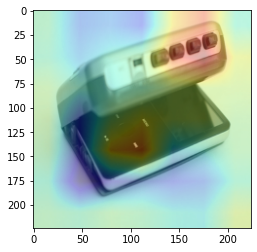

In [8]:
upsampled_hm, hm = bw_get_gradcam_heatmap(model, img_batch, model.features)
cpr2_upsampled_hm, cpr2_hm = bw_get_gradcam_heatmap(cpr2_model, img_batch, cpr2_model.features)
cpr4_upsampled_hm, cpr4_hm = bw_get_gradcam_heatmap(cpr4_model, img_batch, cpr4_model.features)
cpr8_upsampled_hm, cpr8_hm = bw_get_gradcam_heatmap(cpr8_model, img_batch, cpr8_model.features)
cpr16_upsampled_hm, cpr16_hm = bw_get_gradcam_heatmap(cpr16_model, img_batch, cpr16_model.features)
cpr16_upsampled_hm, cpr32_hm = bw_get_gradcam_heatmap(cpr32_model, img_batch, cpr32_model.features)
cpr16_upsampled_hm, cpr64_hm = bw_get_gradcam_heatmap(cpr64_model, img_batch, cpr64_model.features)

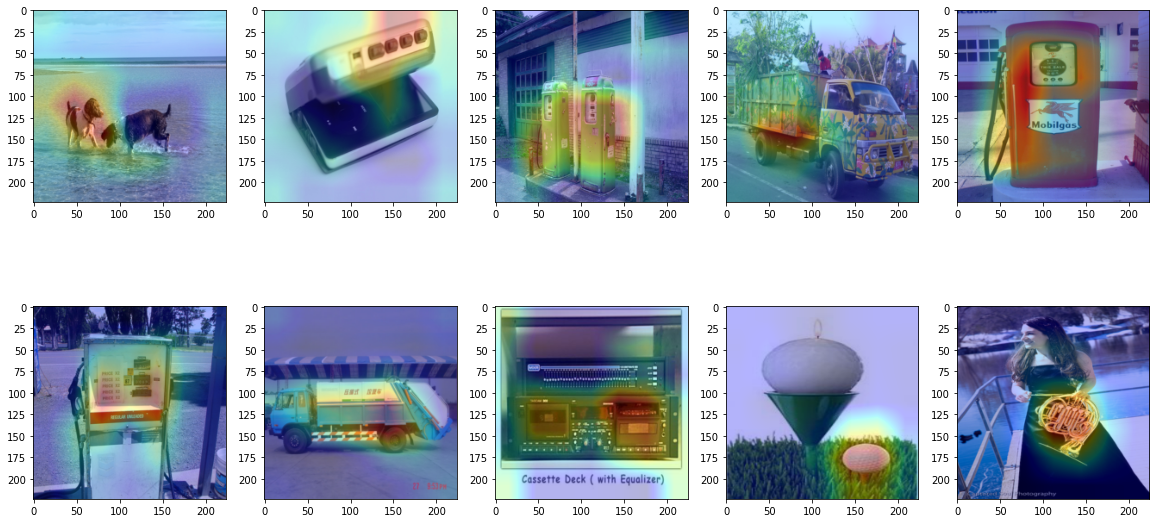

In [9]:
fig, axes = plt.subplots(2,5, figsize=(20,10))
axes = axes.flatten()
for i in range(10):
    axes[i].imshow(img_batch[i].detach().cpu().permute(1,2,0))
    axes[i].imshow(upsampled_hm[i], cmap='jet', alpha=0.3)

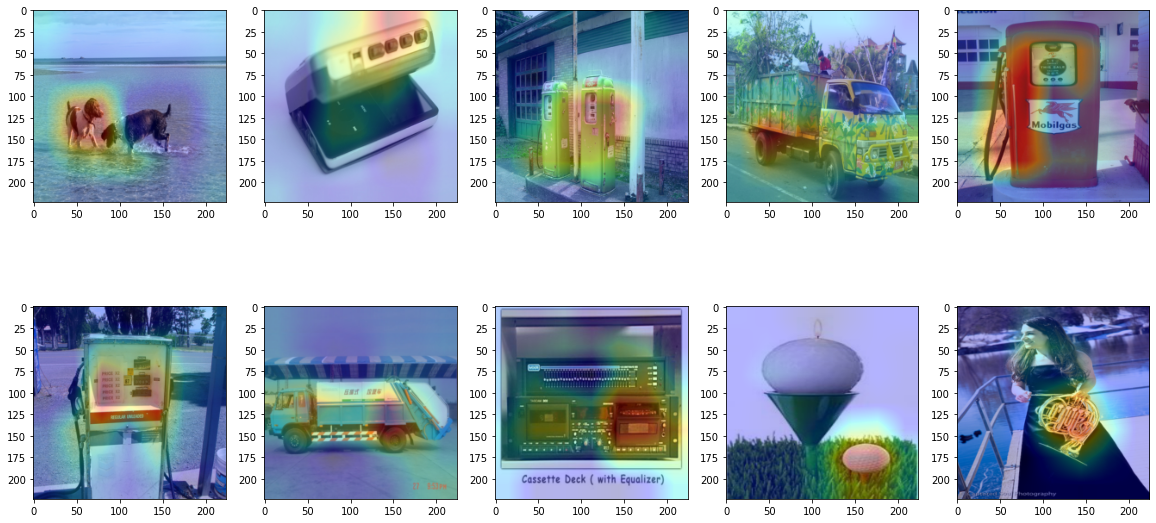

In [10]:
fig, axes = plt.subplots(2,5, figsize=(20,10))
axes = axes.flatten()
for i in range(10):
    axes[i].imshow(img_batch[i].detach().cpu().permute(1,2,0))
    axes[i].imshow(cpr4_upsampled_hm[i], cmap='jet', alpha=0.3)

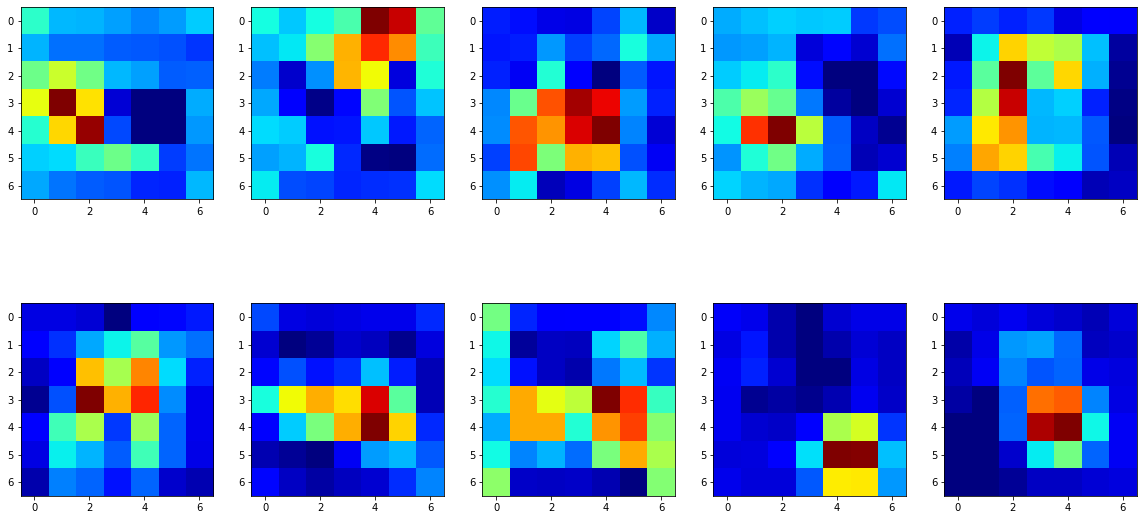

In [12]:
fig, axes = plt.subplots(2,5, figsize=(20,10))
axes = axes.flatten()
for i in range(10):
    axes[i].imshow(img_batch[i].detach().cpu().permute(1,2,0))
    axes[i].imshow(hm[i], cmap='jet')

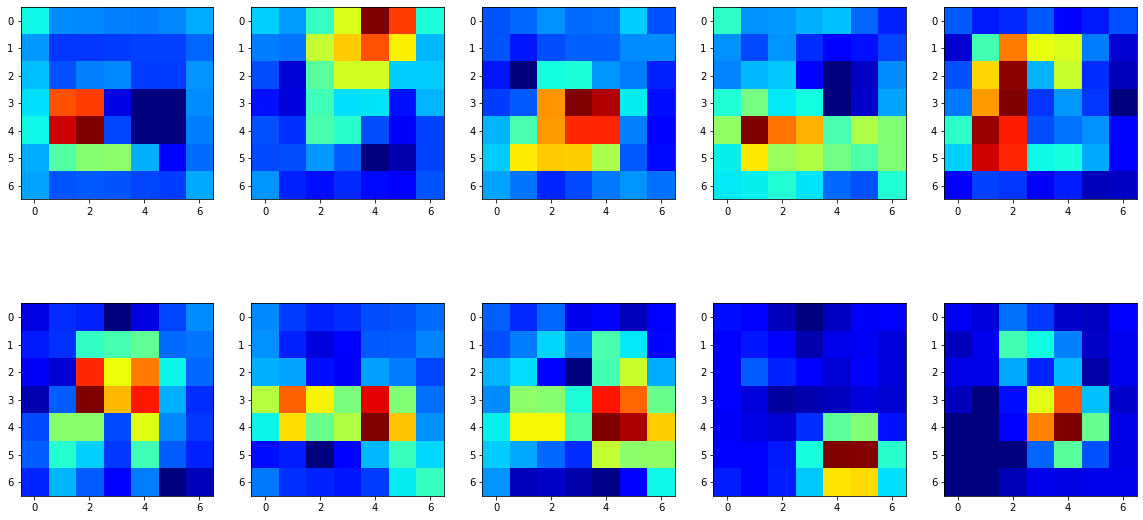

In [13]:
fig, axes = plt.subplots(2,5, figsize=(20,10))
axes = axes.flatten()
for i in range(10):
    axes[i].imshow(img_batch[i].detach().cpu().permute(1,2,0))
    axes[i].imshow(cpr4_hm[i], cmap='jet')

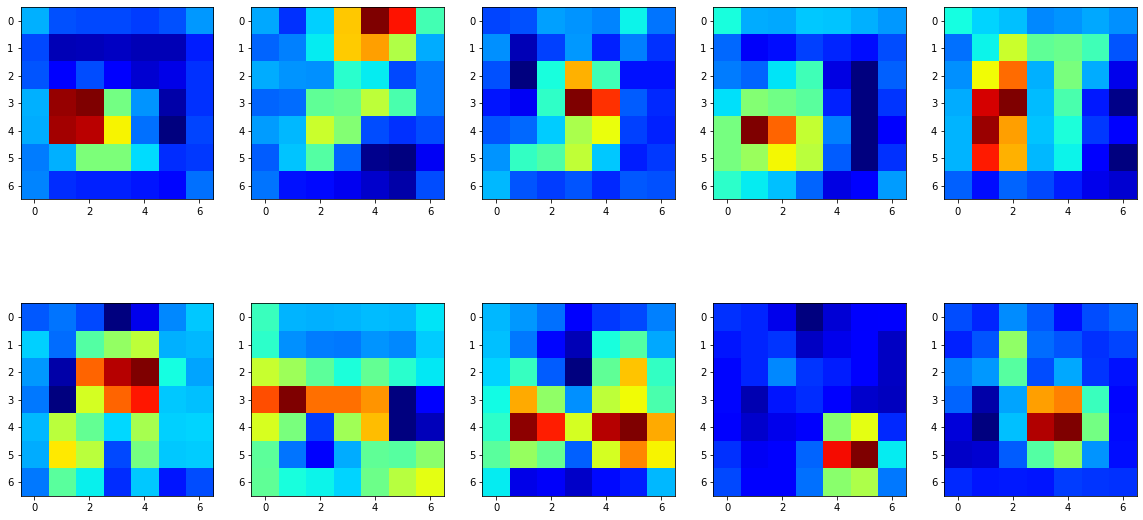

In [14]:
fig, axes = plt.subplots(2,5, figsize=(20,10))
axes = axes.flatten()
for i in range(10):
    axes[i].imshow(img_batch[i].detach().cpu().permute(1,2,0))
    axes[i].imshow(cpr8_hm[i], cmap='jet')

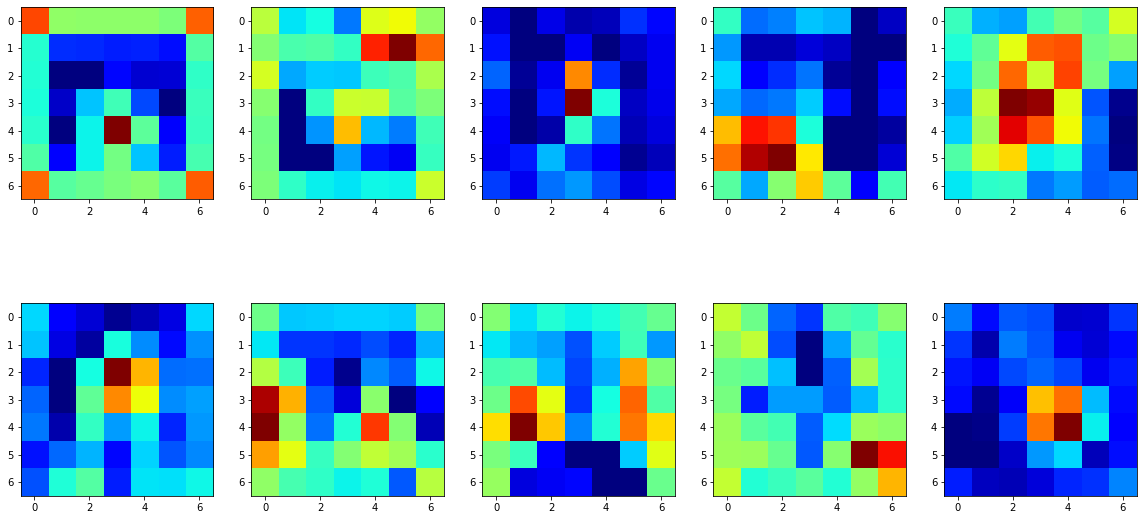

In [16]:
fig, axes = plt.subplots(2,5, figsize=(20,10))
axes = axes.flatten()
for i in range(10):
    axes[i].imshow(img_batch[i].detach().cpu().permute(1,2,0))
    axes[i].imshow(cpr32_hm[i], cmap='jet')

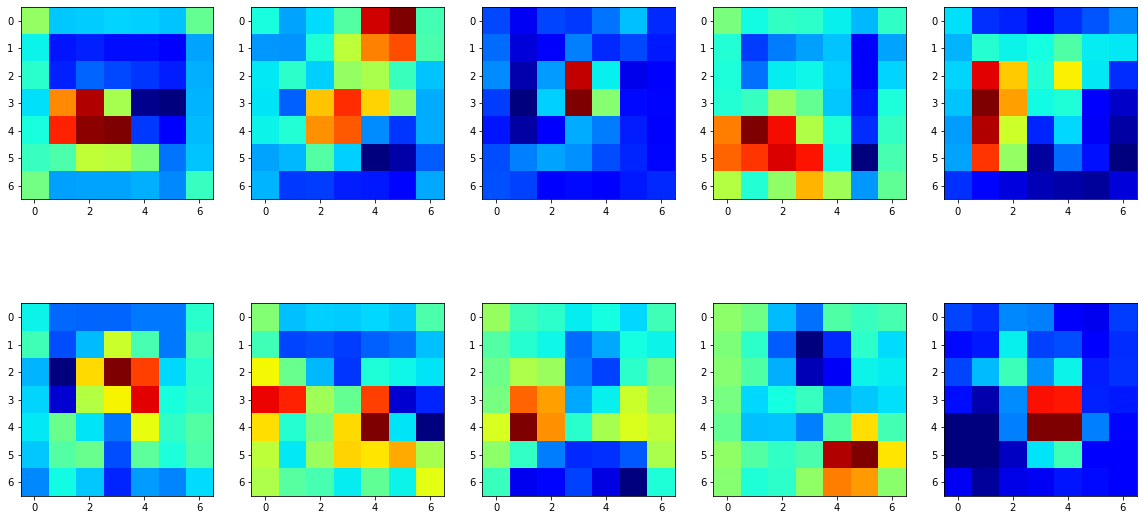

In [17]:
fig, axes = plt.subplots(2,5, figsize=(20,10))
axes = axes.flatten()
for i in range(10):
    axes[i].imshow(img_batch[i].detach().cpu().permute(1,2,0))
    axes[i].imshow(cpr16_hm[i], cmap='jet')

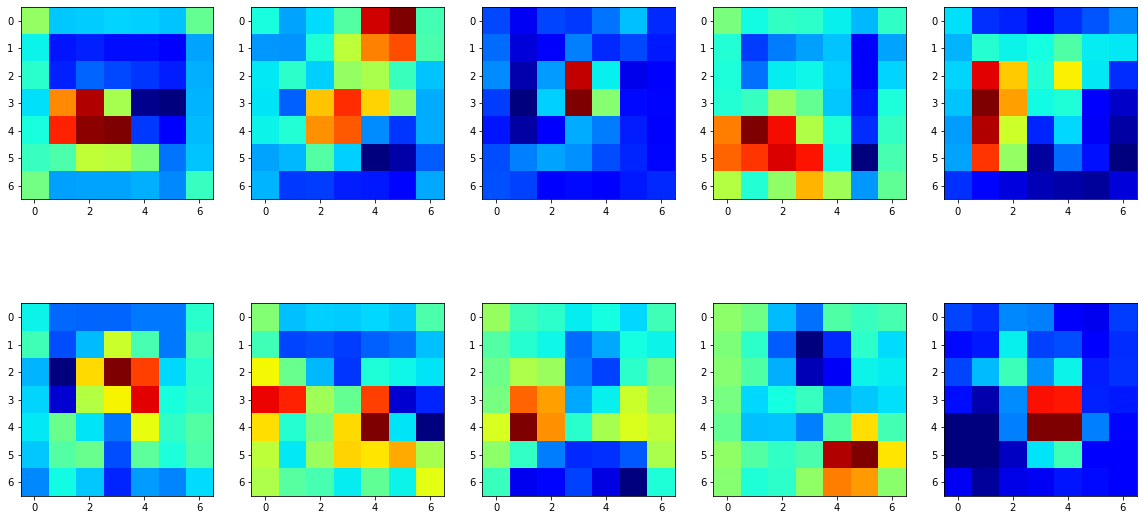

In [15]:
fig, axes = plt.subplots(2,5, figsize=(20,10))
axes = axes.flatten()
for i in range(10):
    axes[i].imshow(img_batch[i].detach().cpu().permute(1,2,0))
    axes[i].imshow(cpr64_hm[i], cmap='jet')

In [18]:
hm.sum().item(), cpr2_hm.sum().item(), cpr4_hm.sum().item(), cpr8_hm.sum().item(), cpr16_hm.sum().item(), cpr32_hm.sum().item(), cpr64_hm.sum().item()

(105.89171600341797,
 99.52928161621094,
 115.84072875976562,
 146.12017822265625,
 192.30406188964844,
 162.44334411621094,
 170.86953735351562)

In [19]:
hm.mean().item(), cpr2_hm.mean().item(), cpr4_hm.mean().item(), cpr8_hm.mean().item(), cpr16_hm.mean().item(), cpr32_hm.mean().item(), cpr64_hm.mean().item()

(0.135065957903862,
 0.12695062160491943,
 0.14775602519512177,
 0.18637777864933014,
 0.2452857941389084,
 0.2071981430053711,
 0.21794584393501282)

In [20]:
hm.var().item(), cpr2_hm.var().item(), cpr4_hm.var().item(), cpr8_hm.var().item(), cpr16_hm.var().item(), cpr32_hm.var().item(), cpr64_hm.var().item()

(0.020061587914824486,
 0.016875840723514557,
 0.017598027363419533,
 0.01803615689277649,
 0.02349441684782505,
 0.02655259147286415,
 0.036212049424648285)

In [21]:
hm.count_nonzero().item(), cpr2_hm.count_nonzero().item(), cpr4_hm.count_nonzero().item(), cpr8_hm.count_nonzero().item(), cpr16_hm.count_nonzero().item(), cpr32_hm.count_nonzero().item(), cpr64_hm.count_nonzero().item()

(757, 764, 757, 759, 755, 711, 696)

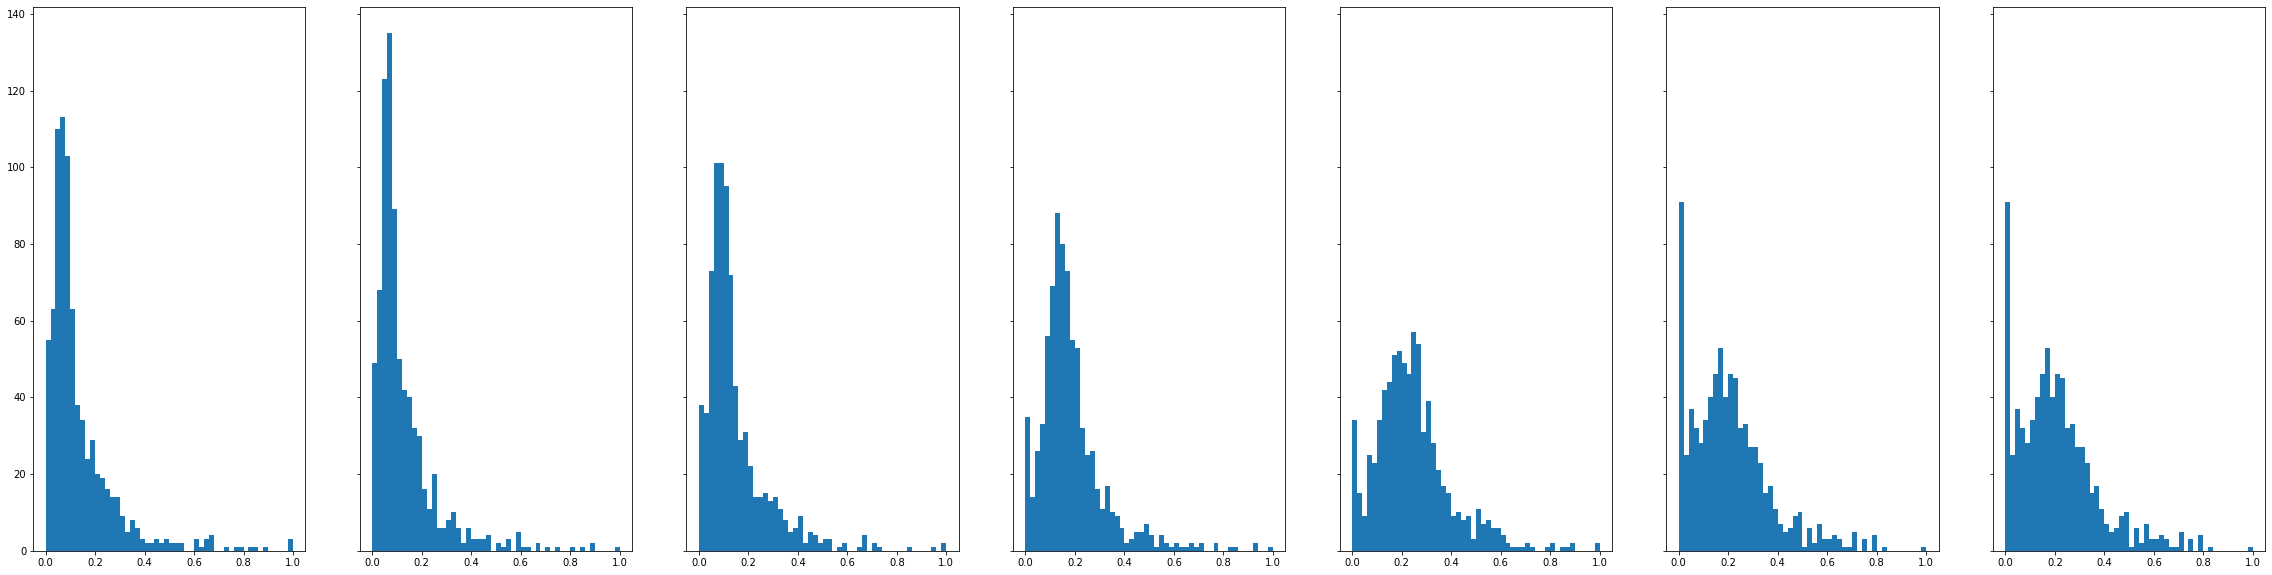

In [22]:
fig, axes = plt.subplots(1,7, figsize=(40,10), sharey=True)
axes=axes.flatten()
_ = axes[0].hist(hm[:100].flatten().numpy(), bins=50)
_ = axes[1].hist(cpr2_hm[:100].flatten().numpy(), bins=50)
_ = axes[2].hist(cpr4_hm[:100].flatten().numpy(), bins=50)
_ = axes[3].hist(cpr8_hm[:100].flatten().numpy(), bins=50)
_ = axes[4].hist(cpr16_hm[:100].flatten().numpy(), bins=50)
_ = axes[5].hist(cpr32_hm[:100].flatten().numpy(), bins=50)
_ = axes[6].hist(cpr32_hm[:100].flatten().numpy(), bins=50)

#### AVG L1 Distances

In [24]:
print((cpr2_hm - cpr4_hm).norm(p=1)/hm.shape[0])
print((cpr2_hm - cpr8_hm).norm(p=1)/hm.shape[0])
print((cpr2_hm - cpr16_hm).norm(p=1)/hm.shape[0])
print((cpr2_hm - cpr32_hm).norm(p=1)/hm.shape[0])
print((cpr2_hm - cpr64_hm).norm(p=1)/hm.shape[0])

tensor(1.8349)
tensor(3.8076)
tensor(6.9333)
tensor(6.2499)
tensor(7.2586)


In [25]:
print((cpr4_hm - cpr8_hm).norm(p=1)/hm.shape[0])
print((cpr4_hm - cpr16_hm).norm(p=1)/hm.shape[0])
print((cpr4_hm - cpr32_hm).norm(p=1)/hm.shape[0])
print((cpr4_hm - cpr64_hm).norm(p=1)/hm.shape[0])

tensor(2.8604)
tensor(6.0022)
tensor(5.5817)
tensor(6.5717)


In [26]:
print((cpr8_hm - cpr16_hm).norm(p=1)/hm.shape[0])
print((cpr8_hm - cpr32_hm).norm(p=1)/hm.shape[0])
print((cpr8_hm - cpr64_hm).norm(p=1)/hm.shape[0])

tensor(4.2450)
tensor(4.5222)
tensor(5.8507)


In [27]:
print((cpr16_hm - cpr32_hm).norm(p=1)/hm.shape[0])
print((cpr16_hm - cpr64_hm).norm(p=1)/hm.shape[0])

tensor(3.7446)
tensor(4.8197)


In [28]:
print((cpr32_hm - cpr64_hm).norm(p=1)/hm.shape[0])

tensor(3.5141)
